# Figure panels showing BAMBI performance and behavior

In [1]:
import numpy as np
import pandas as pd
import jax.numpy as jnp
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm.auto import tqdm
from aging.plotting import (
    figure,
    format_plots,
    add_identity,
    PLOT_CONFIG,
    save_factory,
    COLORMAPS
)
from copy import deepcopy
from toolz import valmap, keyfilter, pluck
from aging.behavior.bio_age_model import fit_model, masked_xval
from scipy.spatial.distance import pdist, squareform

In [2]:
format_plots()
saver = save_factory(PLOT_CONFIG.save_path / "fig2-bambi", tight_layout=False)

In [3]:
def zscore(ser: pd.Series):
    return (ser - ser.mean()) / ser.std()


def demean(ser: pd.Series):
    return ser - ser.mean()


def quantile(n):
    def percentile_(x):
        return x.quantile(n)
    percentile_.__name__ = 'q_{:0.02f}'.format(n)
    return percentile_


In [4]:
keep_syllables = np.loadtxt('/n/groups/datta/win/longtogeny/data/ontogeny/version_11/to_keep_syllables_raw.txt', dtype=int)
df = pd.read_parquet(
    "/n/groups/datta/win/longtogeny/data/ontogeny/version_11/ontogeny_males_raw_counts_matrix_v00.parquet"
)
df = df[keep_syllables]
# mask = df.index.get_level_values("age") < 100
# df = df[mask].copy()

size_df = pd.read_parquet(
    '/n/groups/datta/win/longtogeny/data/ontogeny/version_11/ontogeny_males_mouse_area_df_v00.parquet'
)
# mask = size_df.index.get_level_values("age") < 100
# size_df = size_df[mask].copy()
age_cut = pd.cut(size_df.index.get_level_values('age'), 19)

size_df.loc[size_df['quant_0.5'] == 0, 'quant_0.5'] = np.nan
sizes_col = size_df['quant_0.5']
sizes_col = sizes_col.groupby('mouse').apply(lambda df: df.sort_index(level='age').interpolate()).droplevel(0)

# sizes_col = zscore(sizes_col.groupby(age_cut, observed=True).transform(demean))
sizes_col = sizes_col.groupby(age_cut, observed=True).transform(zscore)
sizes_col = sizes_col.fillna(0)
sizes_col = sizes_col.loc[df.index]

# make sure df matches sizes
df = df.loc[sizes_col.index]

age = jnp.array(df.index.get_level_values("age"))
syllable_counts_jax = jnp.array(df.astype(float))

In [7]:
features = {
    "ages": age,  # models >= 1
    "counts": syllable_counts_jax + 1,  # models >= 1
    "sizes": sizes_col.to_numpy(),  # models > 1
}

hypparams = {
    "min_age": 1,
    "max_age": age.max() + 5,
    "age_sd": 10,  # weeks
    "n_age_samples": 1000,
    "n_splines": 4,
    "n_syllables": syllable_counts_jax.shape[1],
    "n_development_splines": 4,
    "scale": 150,
    "normalize_by_softmax": True,
    "n_keep_sylls": 25,
    "n_sessions": len(syllable_counts_jax),
    # "n_animals": len(mouse_ids),
    "lr": 0.2,
    "n_opt_iter": 350,
}

In [6]:
keep_keys = ['heldout_ll', 'heldout_r2_total', 'heldout_r2_total_v3', 'true_ages', 'bio_ages']

In [7]:
outs = []

for age_sd in tqdm(range(1, 20, 1)):

    hypparams["age_sd"] = float(age_sd)

    tmp = masked_xval(features, hypparams, 2, n_repeats=7, disable_tqdm=True)
    tmp = valmap(lambda v: keyfilter(lambda k: k in keep_keys, v), tmp)
    for k, v in tmp.items():
        outs.append({
            "repeat": k,
            "age_sd": age_sd,
            **v
        })
outs_df = pd.DataFrame(outs)

  0%|          | 0/19 [00:00<?, ?it/s]

In [8]:
optimal_age_sd = outs_df.groupby('age_sd')['heldout_ll'].mean().idxmax()
optimal_age_sd

10

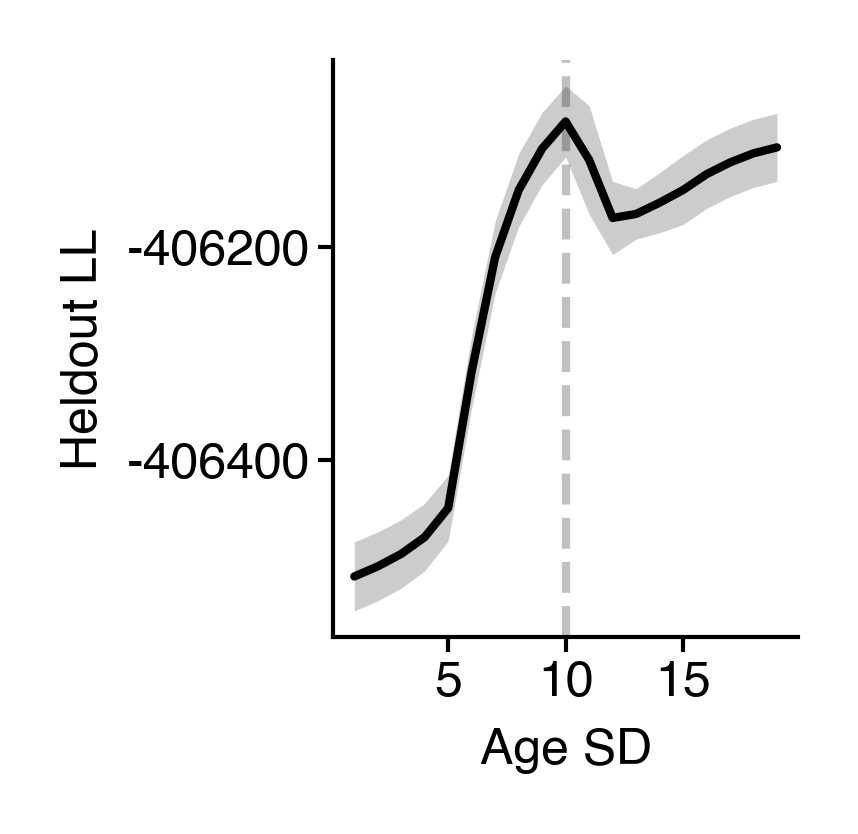

In [9]:
fig = figure(1, 1.25)
ax = sns.lineplot(
    data=outs_df,
    x="age_sd",
    y="heldout_ll",
    errorbar="se",
    err_kws=dict(lw=0),
    color="k",
)
ax.set(ylabel="Heldout LL", xlabel="Age SD")
ax.axvline(optimal_age_sd, ls='--', color='silver', zorder=-1)
sns.despine()
saver(fig, "ontogeny-males-heldout-age-sd-optimization");

## Heldout r2 for linear, age only, and age+size models

In [7]:
# optimal_age_sd = 10

In [19]:
n_repeats = 30

In [20]:
hypparams['age_sd'] = float(optimal_age_sd)

mdl0 = masked_xval(features, hypparams, 0, n_repeats=n_repeats)
r2_0 = list(pluck('heldout_r2_total_v3', mdl0.values()))

mdl1 = masked_xval(features, hypparams, 1, n_repeats=n_repeats)
r2_1 = list(pluck('heldout_r2_total_v3', mdl1.values()))

mdl2 = masked_xval(features, hypparams, 2, n_repeats=n_repeats)
r2_2 = list(pluck('heldout_r2_total_v3', mdl2.values()))

hypparams['age_sd'] = 1e-6
mdl0_1 = masked_xval(features, hypparams, 1, n_repeats=n_repeats)
r2_0_1 = list(pluck('heldout_r2_total_v3', mdl0_1.values()))

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

In [21]:
# shuffle syllables
np.random.seed(0)
shuff_features = deepcopy(features)
hypparams['age_sd'] = float(optimal_age_sd)

out = {}
for i in tqdm(range(n_repeats)):
    perm = np.array([np.random.permutation(58) for _ in range(len(syllable_counts_jax))])
    shuff = syllable_counts_jax[np.arange(len(syllable_counts_jax))[:, None], perm]
    shuff_features['counts'] = shuff
    tmp = masked_xval(shuff_features, hypparams, model_version=2, n_repeats=1, disable_tqdm=True, seed=i)
    out[i] = tmp[0]

r2_shuff = list(pluck('heldout_r2_total_v3', out.values()))

  0%|          | 0/30 [00:00<?, ?it/s]

In [25]:
# shuffle ages
np.random.seed(0)
shuff_ages = deepcopy(features)
hypparams['age_sd'] = float(optimal_age_sd)

out = {}
for i in tqdm(range(n_repeats)):
    shuff = np.random.permutation(len(features['ages']))
    shuff_ages['ages'] = features['ages'][shuff]
    tmp = masked_xval(shuff_ages, hypparams, model_version=2, n_repeats=1, disable_tqdm=True, seed=i)
    out[i] = tmp[0]

r2_age_shuff = list(pluck('heldout_r2_total_v3', out.values()))

  0%|          | 0/30 [00:00<?, ?it/s]

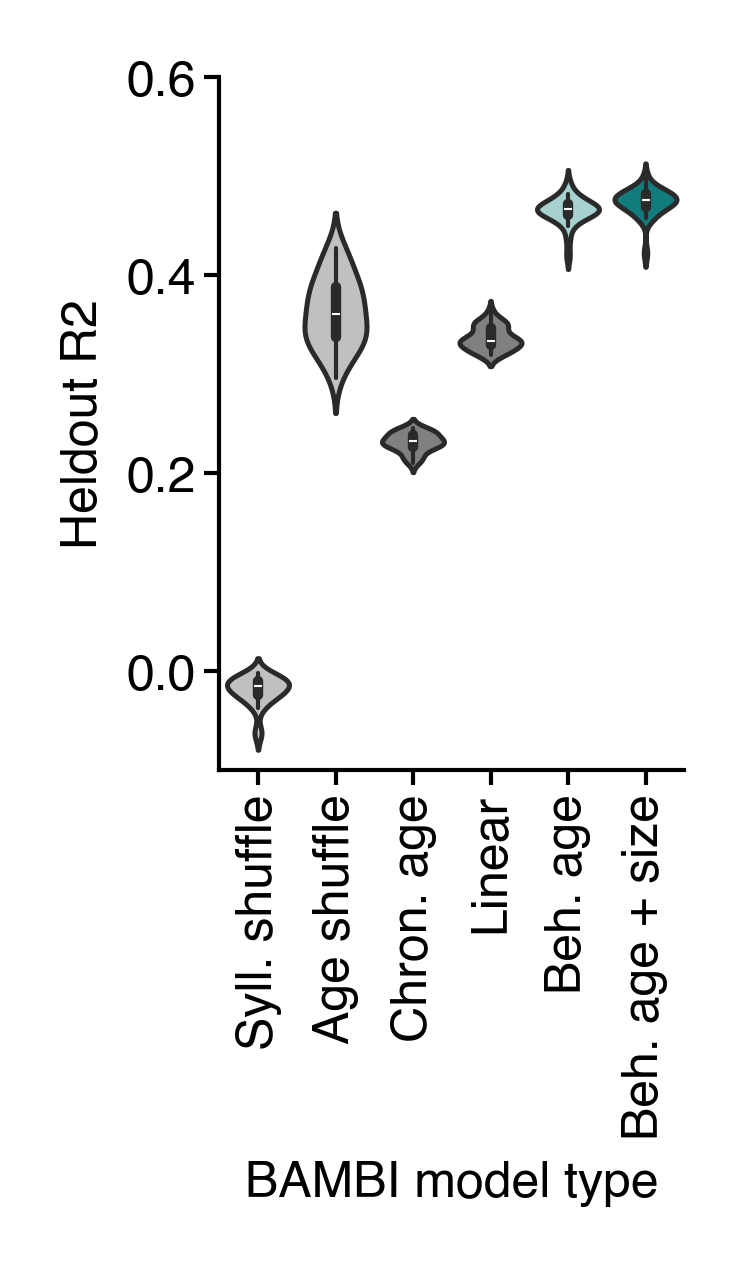

In [31]:
plt_data = {
    "Syll. shuffle": r2_shuff,
    "Age shuffle": r2_age_shuff,
    "Chron. age": r2_0_1,
    "Linear": r2_0,
    "Beh. age": r2_1,
    "Beh. age + size": r2_2,
}

fig = figure(1, 1.5)
ax = sns.violinplot(
    data=plt_data,
    palette=["silver", "silver", "gray", "gray", COLORMAPS.ont_male(50), COLORMAPS.ont_male(255)],
    width=0.8, linewidth=0.6,
    inner_kws=dict(box_width=1.25, whis_width=0.5),
)
ax.set(
    xlabel="BAMBI model type",
    ylabel="Heldout R2",
    ylim=(-0.1, 0.6),
)
plt.xticks(rotation=90)
sns.despine()
saver(fig, "ontogeny-males-heldout-r2-model-comparison");

## Show fits for size and age

## Show sorting w/chronological age and bio age

In [8]:
mdl = fit_model(features, hypparams, 2)

In [11]:
df_copy = pd.read_parquet(
    "/n/groups/datta/win/longtogeny/data/ontogeny/version_11/ontogeny_males_raw_usage_matrix_v00.parquet"
).astype(float)
df_copy = df_copy[keep_syllables]
df_copy = df_copy.loc[df.index]

In [12]:
df_copy['beh_age'] = mdl['bio_ages']
df_copy = df_copy.set_index('beh_age', append=True)

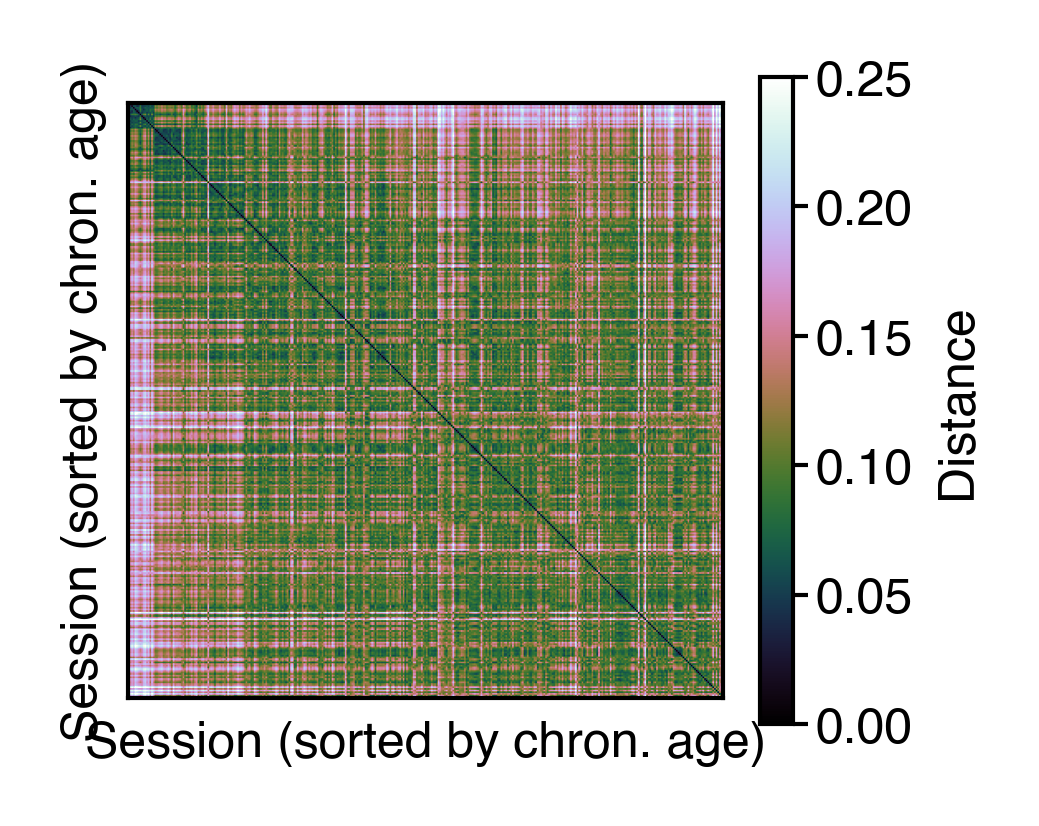

In [13]:
fig = figure(1.6, 1.4)
d = pdist(df_copy.sort_index(level='age'), metric='euclidean')
d = squareform(d)
plt.imshow(d, cmap='cubehelix', vmax=0.25)
plt.colorbar(label="Distance")
plt.xticks([])
plt.yticks([])
plt.xlabel('Session (sorted by chron. age)')
plt.ylabel('Session (sorted by chron. age)')
saver(fig, 'ontogeny-males-chron-age-distance-matrix');

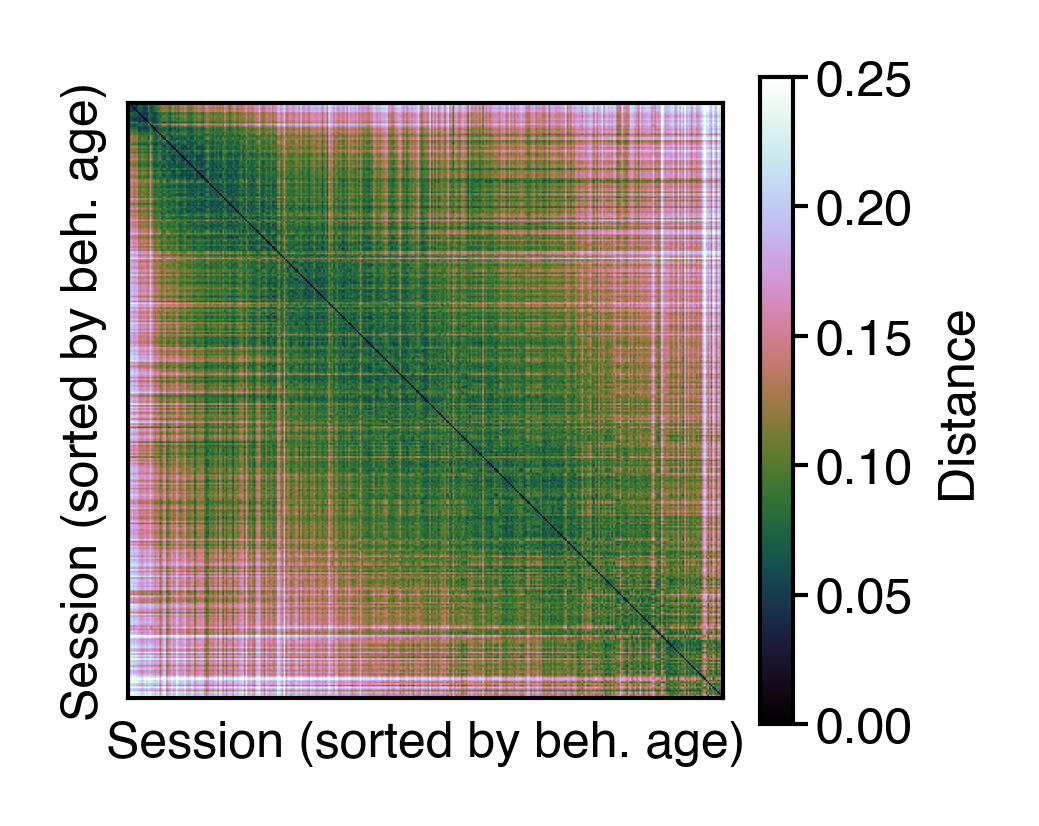

In [14]:
fig = figure(1.6, 1.4)
d = pdist(df_copy.sort_index(level='beh_age'), metric='euclidean')
d = squareform(d)
plt.imshow(d, cmap='cubehelix', vmax=0.25)
plt.colorbar(label="Distance")
plt.xticks([])
plt.yticks([])
plt.xlabel('Session (sorted by beh. age)')
plt.ylabel('Session (sorted by beh. age)')
saver(fig, 'ontogeny-males-beh-age-distance-matrix');

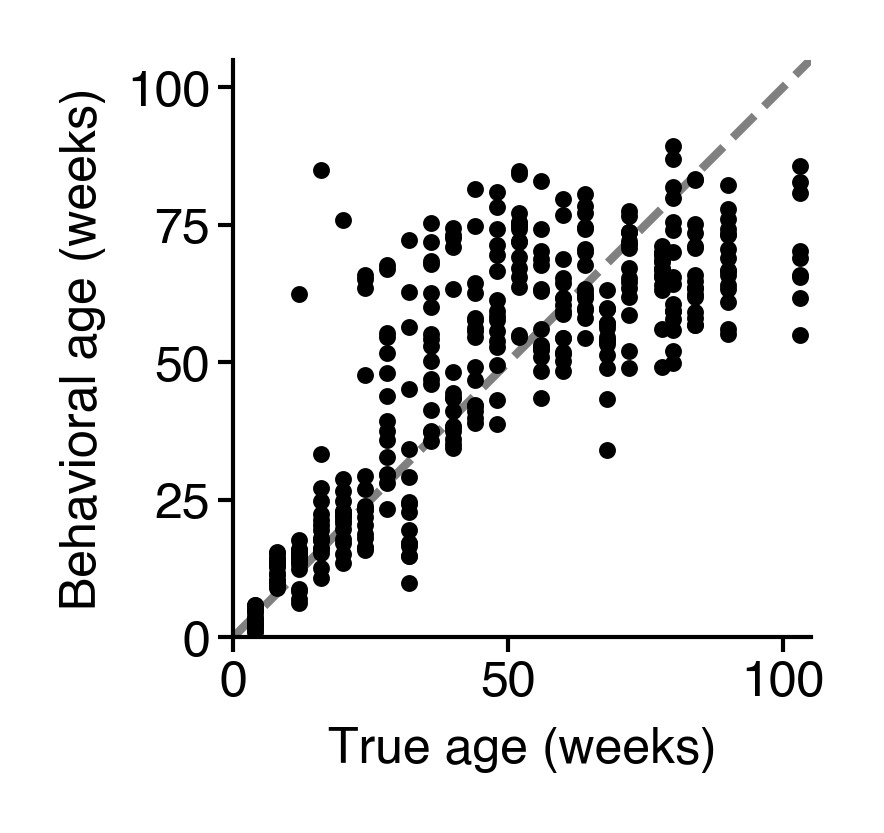

In [24]:
fig = figure(1.25, 1.25)
ax = fig.gca()
ax.scatter(mdl['true_ages'], mdl['bio_ages'], color='k', s=1.5)
ax.set(xlabel="Chronological age (weeks)", ylabel="Behavioral age (weeks)", aspect='equal', xlim=(0, 105), ylim=(0, 105))
add_identity(ax, color='gray', ls='--', zorder=-1)
sns.despine()
saver(fig, "ontogeny-male-bio-ages");

In [8]:
males = masked_xval(features, hypparams, 2, n_repeats=10)
bio_age_samples = [pd.Series(v['bio_ages'], index=df.index) for v in males.values()]
bio_age_samples = pd.DataFrame(bio_age_samples).T
bio_age_samples.to_parquet('/n/scratch/users/w/wg41/bio-age-model/ontogeny-predictions.parquet')

  0%|          | 0/10 [00:00<?, ?it/s]

## PCA on model predictions

In [9]:
from sklearn.decomposition import PCA

In [10]:
list(mdl)

['params',
 'heldout_ll',
 'loss',
 'bio_ages',
 'age_likelihoods',
 'true_ages',
 'init_components',
 'concentrations',
 'concentration_components',
 'predicted_counts',
 'counts',
 'r2_total',
 'r2_each']

In [11]:
mdl['predicted_counts'].shape

(360, 58)

In [12]:
pc = mdl['predicted_counts']
pc = pc / pc.sum(1, keepdims=True)

In [13]:
pca = PCA(n_components=2)
scores = pca.fit_transform(pc)
scores_df = pd.DataFrame(scores, index=df.index)

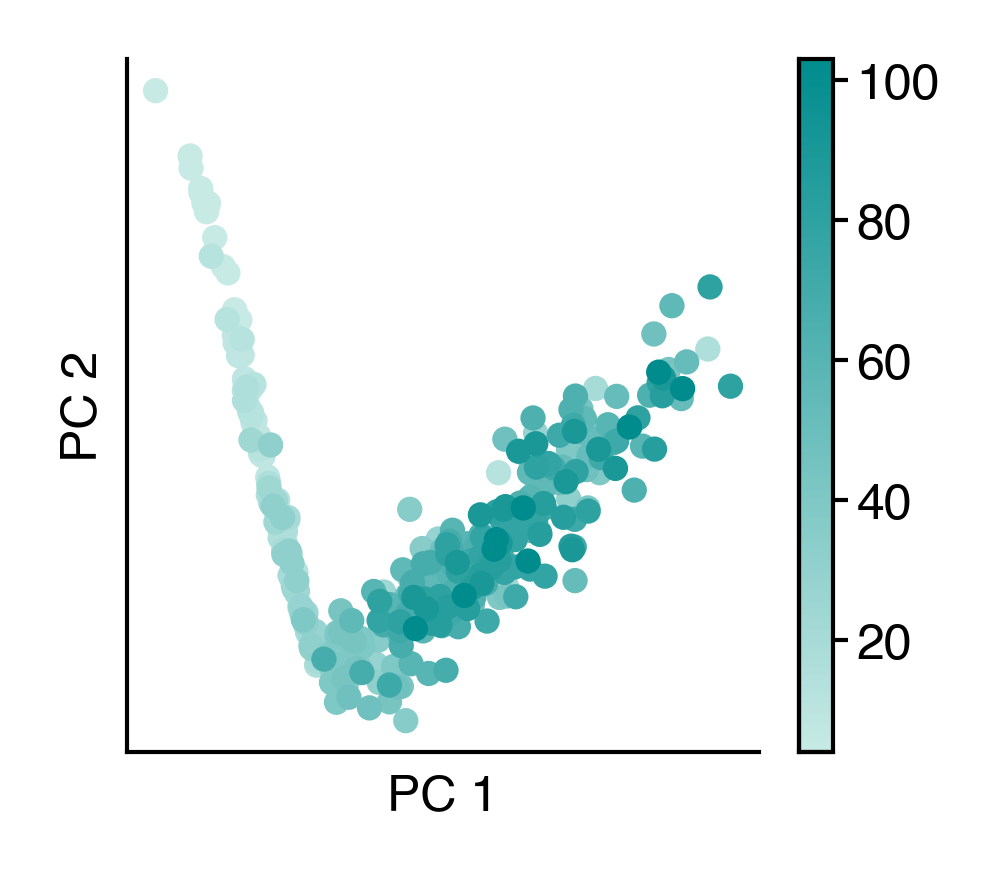

In [15]:
fig = figure(1.7, 1.5)
ax = fig.gca()
im = ax.scatter(
    scores_df[0],
    scores_df[1],
    c=scores_df.index.get_level_values("age"),
    cmap=COLORMAPS.ont_male,
    s=5,
)
cb = fig.colorbar(im, ax=ax)
ax.set(xticks=[], yticks=[], xlabel="PC 1", ylabel="PC 2")
sns.despine()
saver(fig, "model-based-pca-males");

## Show methylation fits

In [15]:
bio_age_samples = pd.read_parquet('/n/scratch/users/w/wg41/bio-age-model/ontogeny-predictions.parquet')

In [16]:
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import ElasticNet
from sklearn.preprocessing import StandardScaler
from sklearn.cross_decomposition import PLSRegression
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import cross_val_predict, KFold, ParameterGrid, LeaveOneOut

In [17]:
meth_df = pd.read_parquet(
    "/n/groups/datta/win/longtogeny/data/epigenetics/analysis/epi_df.parquet"
)

meth_df = meth_df.astype(float).sort_index(level='age')

In [18]:
beh_reindexed = bio_age_samples.loc[pd.IndexSlice[:, :, :, :, meth_df.index.get_level_values('uuid')], :].copy()
beh_reindexed = pd.DataFrame(beh_reindexed.mean(1).rename('bio_age'))
age = beh_reindexed.index.get_level_values('age')

In [19]:
resid = beh_reindexed.groupby('age').rank()
resid = zscore(resid.to_numpy())

In [30]:
keep_genes = meth_df.std() > 0.05
keep_genes = keep_genes.index[keep_genes]
filt_meth_df = meth_df[keep_genes]

In [20]:
pipeline = make_pipeline(
    StandardScaler(),
    GradientBoostingRegressor(),
    # SVR(kernel='linear'),
    # RandomForestRegressor(),
    # ElasticNet(),
)

params = {
    # 'svr__C': np.logspace(-6, 1, 11),
    'elasticnet__l1_ratio': np.linspace(0.1, 1, 6),
    'elasticnet__alpha': np.logspace(-3, 0, 8),
}

grid = ParameterGrid(params)

In [ ]:
scores = []
for i in range(10):
    _score = r2_score(
        resid.squeeze(),
        cross_val_predict(
            pipeline,
            meth_df,
            resid.squeeze(),
            # cv=LeaveOneOut(),
            cv=KFold(n_splits=6, random_state=i, shuffle=True),
            n_jobs=-1,
        ).squeeze(),
    )
    scores.append(_score)
    print(_score)

/home/wg41/miniconda3/envs/aging-gpu/lib/python3.10/site-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


[0.3108369400770229]
[0.3108369400770229, -0.21058311277098785]
